# Prediction of lung cancer subtype with a nested cross-validation pipeline

This jupyter notebook aims to illustrate our nested cross-validation python implementation with a simple example. We study the classification of Non-small cell lung cancer histological subtypes using transcriptomic data.   

**Note** : To run this jupyter notebook, you first need to extract the data set "data.csv" from the zip file "data.zip" (same directory)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## 0. Load the data set

* Data set extracted from ["Defining the Biological Basis of Radiomic Phenotypes in Lung Cancer" Grossman et al. 2017](https://elifesciences.org/articles/23421).<p>  
    
* Expression of **21,766 unique genes** for **224 patients** with Non-small cell lung cancer (NSCLC).<p>  
    
* Gene expression values were measured on a custom Rosetta/Merck Affymetrix 2.0 microarray chipset and normalized with the robust multi-array average (RMA) algorithm.

In [2]:
df = pd.read_csv("data.csv" , index_col=0)
print(df.shape[0] , " samples with histological information")
print(df.shape[1] - 1, " unique genes")
df.head()

224  samples with histological information
21766  unique genes


,geneid.3643,geneid.84263,geneid.7171,geneid.2934,geneid.11052,geneid.1241,geneid.6453,geneid.57541,geneid.9349,geneid.11165,...,geneid.1572,geneid.8551,geneid.26784,geneid.26783,geneid.26782,geneid.26779,geneid.26778,geneid.26777,geneid.100132941,histology
RadioGenomic-001,4.871974,8.202717,9.819270,8.492876,7.712078,7.063770,10.247928,8.614199,5.649873,7.049535,...,3.608932,6.584940,6.109479,4.685262,5.636591,3.165858,9.095403,3.477838,5.435395,adeno
RadioGenomic-002,4.884625,7.930854,9.777377,8.011972,7.862847,8.735264,10.122395,9.285171,8.348704,7.146661,...,3.527583,6.884115,6.724831,5.413868,6.310839,3.306311,9.579478,3.445292,5.280185,squamous
RadioGenomic-003,6.544434,7.952210,10.185486,9.233013,6.840010,9.234796,10.790635,7.844318,3.943773,7.151620,...,4.327221,7.774516,6.727119,5.079287,5.938707,3.677257,9.817884,3.578696,5.879146,other
RadioGenomic-004,7.951348,7.607591,9.666986,7.831439,7.081398,8.202348,10.632971,8.918782,4.857194,9.226158,...,3.571539,5.680616,5.882869,4.717828,6.143484,2.819706,8.918029,3.776916,4.909247,adeno
RadioGenomic-006,5.888098,7.357627,10.091727,7.951360,6.990130,7.073570,9.687328,8.537944,6.253872,7.541714,...,3.435329,7.009447,5.809794,4.576371,5.523023,3.164927,8.552383,3.376662,5.805264,adeno


adeno       129
squamous     61
other        34
Name: histology, dtype: int64

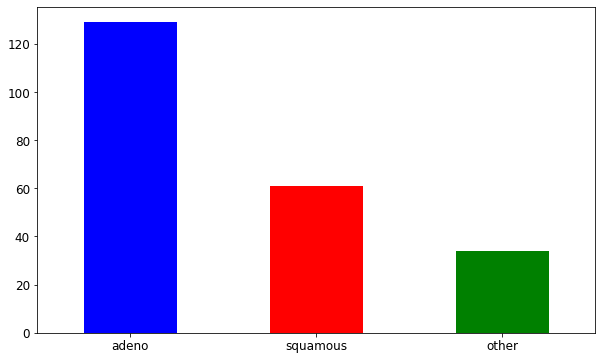

In [3]:
fig, ax = plt.subplots(figsize = (10 , 6))
df['histology'].value_counts().plot.bar(rot = 0 , color = ['blue' , 'red' , 'green'], fontsize = 12)
df['histology'].value_counts()

Here, we tackle the binary classification problem "adeno vs (squamous + other)" defining the binary target y (0 : adeno , 1 : squamours or other).

In [4]:
X = df.iloc[: , :-1].values
y = 1*(df.iloc[: , -1] != 'adeno').values

## 1. Define the pipeline
   
Defining complex pipelines with several operations that will be fitted through the different folds is an easy task thanks to the [Pipeline](https://scikit-learn.org/stable/modules/compose.html) tool of scikit-learn. You can integrate any estimator that is compatible with the sklearn API (even custom-made !).   
    
One of the main advantage of nested_cross_val is that once your pipeline has been created, you do not have to worry about it anymore. It will be fitted through the different folds of a nested cross-validation scheme without any data leakage.   

Here, to simply illustrate our nested cross-validation implementation, we use a pipeline composed by a PCA step and a logistic regression for the classification of the NSCLC subtype.

In [5]:
from sklearn import set_config
set_config(display='diagram')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

For simplicity (and a later analysis of feature importances), we would like to fix the number of PCA components. To choose an appropriate number of components we can first look at the PCA decomposition of the full data set.   

This is not, in fact, a trivial question. We chose a number of 20 components as it seemed to be a reasonable compromise between a limited number of components and a large fraction of the variance explained. Obviously for further analyses this choice will need to be tackled more cautiously.

Text(0, 0.5, 'explained variance')

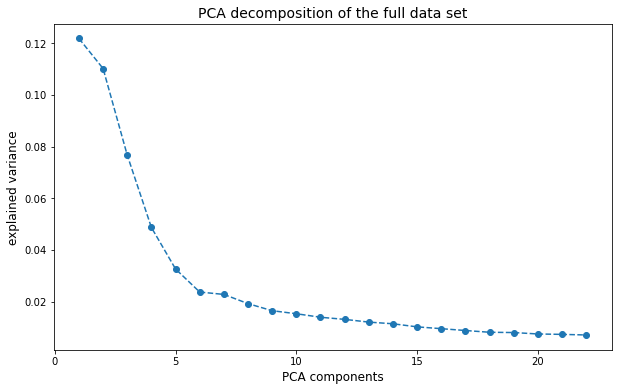

In [6]:
pca_full = PCA(n_components = 0.6 , whiten = True).fit(X)

fig , ax = plt.subplots(figsize = (10 , 6))
ax.plot(range(1 , len(pca_full.explained_variance_ratio_) +1) , pca_full.explained_variance_ratio_ , linestyle='--', marker='o')
ax.set_title("PCA decomposition of the full data set" , fontsize = 14)
ax.set_xlabel("PCA components" , fontsize = 12)
ax.set_ylabel("explained variance" , fontsize = 12)

In [7]:
pipe = Pipeline(steps=[('PCA' , PCA(n_components = 20 , whiten = True)),
                       ('logistic',LogisticRegression(solver='saga' ,penalty='elasticnet' , max_iter = 2000))
                      ]
                )

pipe

Pipeline(steps=[('PCA', PCA(n_components=20, whiten=True)),
                ('logistic',
                 LogisticRegression(max_iter=2000, penalty='elasticnet',
                                    solver='saga'))])

**Note :** Here we decided not to scale the genes before the PCA step since since we believe that the differences of variability between genes carry some relevant information.

## 2. Nested-cross-validation scheme    

Using the parameters "params", "cv_inner", "cv_outer", the user can shape the nested cross-validation scheme to its needs. Scikit-learn proposes a wide range of [cross-validation strategies](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) but you can also use a custom-made CV splitters which yield (train, test) splits as arrays of indices.   

Here we use a simple strategy whose main characteristics are :

* 10 fold outer cross-validation with 5 fold inner cross-validation for hyperparameter tuning (good bias-variance trade-off + keep computational time relatively low).<p>  
    
* Stratified cross-validation (ensure that each fold has the same proportion of observations for both classes).<p>  

* Gridsearch strategy (predefined grid of possible values for hyperparameters).

In [8]:
from nested_cross_val.base import NestedCV
from sklearn.model_selection import StratifiedKFold

#### A brief word about dask   

We added a Dask implementation in our nested_cross_validation (library = 'dask') since it provides elegant solutions to save some precious computational time, optimizing memory and redundant operations through smart parallelization. For simple estimators Dask is not necessarily needed and scikit-learn (library = 'sklearn') will work perfectly. However, for complex pipelines with costly operations we think that Dask can help reducing the computational time significantly.   

Our goal, here, is not to give a detailed tutorial on dask but we still want to draw the reader attention on the "scheduler" parameter. It defines the parallel hardware that will execute the different tasks (you will find more details [here](https://docs.dask.org/en/latest/scheduling.html)). You have three options :   

* You can use the default value (scheduler = None), it will create a default single-machine scheduler with multiple threads. <p>

* You can define a dask.distributed scheduler on your local machine (you will find more details [here](https://docs.dask.org/en/latest/setup/single-distributed.html)). In particular, it provides a very nice interactive dashboard with live information that will help you better understand how the different tasks are executed (we recomend [this tutorial](https://docs.dask.org/en/latest/diagnostics-distributed.html) for more details).<p>
    
* You can also run Dask on a distributed cluster. There are a variety of ways to set this up depending on your cluster. Unfortunatly we do not know enough about it to guide you through (see [here](https://docs.dask.org/en/latest/setup.html) for some explanations).

In [9]:
from dask.distributed import Client
client = Client(processes=False)
client

Client Scheduler: inproc://192.168.1.133/11640/1 Dashboard: http://192.168.1.133:8787/status,Cluster Workers: 1 Cores: 8 Memory: 16.91 GB


In [10]:
param_grid = {'logistic__C': np.logspace(-2, 2, 20) , 'logistic__l1_ratio' : np.arange(0 , 1.1 , 0.1)}

cv_out = StratifiedKFold(n_splits = 10, shuffle = True , random_state = 0)

ncv = NestedCV(estimator = pipe , params = param_grid , cv_inner = 5  , cv_outer = cv_out  , 
               scoring_inner = 'roc_auc' , scoring_outer = {'roc_auc' : 'roc_auc' , 'average_precision' : 'average_precision'} ,
               library = 'dask' , scheduler = client)

In [11]:
start = time.time()
ncv.fit(X , y)
end = time.time()
minutes, seconds = divmod(end - start, 60)
print("Total fitting time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

inner training out fold 0 done ! running time (min): 00:12.62
inner training out fold 1 done ! running time (min): 00:14.72
inner training out fold 2 done ! running time (min): 00:15.21
inner training out fold 3 done ! running time (min): 00:14.41
inner training out fold 4 done ! running time (min): 00:16.21
inner training out fold 5 done ! running time (min): 00:14.82
inner training out fold 6 done ! running time (min): 00:15.44
inner training out fold 7 done ! running time (min): 00:15.99
inner training out fold 8 done ! running time (min): 00:16.25
inner training out fold 9 done ! running time (min): 00:16.90
Total fitting time (min): 02:35.55


In [12]:
client.close()

## 3. Plot scores and hyperparameters

In complement to our nested cross-validation implementation, we provide some plotting tools to visualize the results. Obviously, these are just some suggestions and the user is free to use any custom-made plotting tool having directly access to the scores, the attributes of the estimators and the predictions with methods such as NestedCV.get_predictions(), NestedCV.get_attributes() or the attribute NestedCV.outer_results_.

In [13]:
from nested_cross_val.tools.plotting import plot_roc , plot_PR , plot_score , plot_hyperparameters

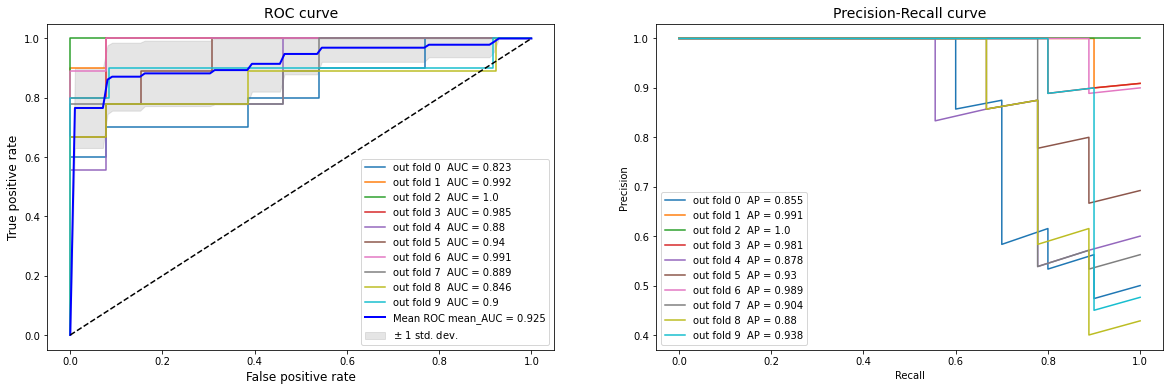

In [14]:
fig , axes = plt.subplots(1 , 2 , figsize = (20, 6))
plot_roc(ncv , ax = axes[0])
plot_PR(ncv , ax = axes[1])

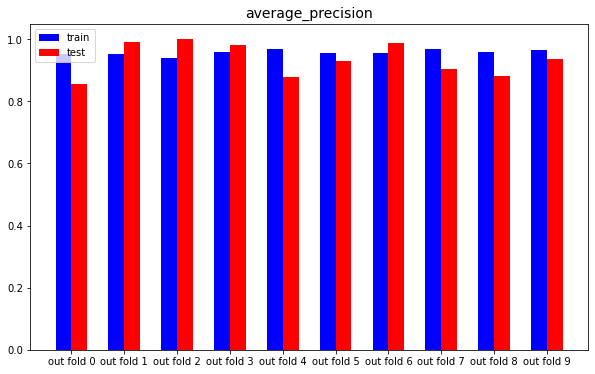

In [15]:
plot_score(ncv , score_name = 'average_precision' , display = 'barplot')

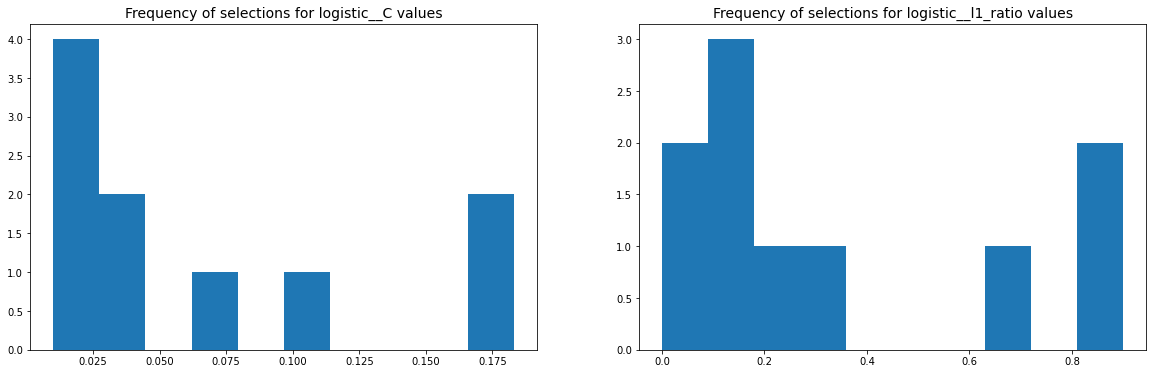

In [16]:
fig , ax = plt.subplots(1 , 2 , figsize = (20 , 6))
plot_hyperparameters(ncv , name = 'logistic__C' , discrete = False , ax = ax[0])
plot_hyperparameters(ncv , name = 'logistic__l1_ratio' , discrete = False , ax = ax[1])

## 4. Feature importance analysis

In complement to our nested cross-validation implementation we also provide some tools for feature importance analysis. In particular, for pipelines with a step of feature transformation (ex : PCA) we provide a clustering tool that returns clusters of components (each one represented by a "consensus" component) and the associated feature importances accross the folds.   

Here are the three main steps of this method for PCA components :

1. Cluster the PCA components across the folds - in total 20x10 components gathered in 20 clusters using hierarchical clustering and Pearson correlation (within sample space).<p>   
    
2. For each fold, each component is associated with its corresponding cluster and we can then perform stability analysis (e.g How many times the cluster i has been selected across the k folds ?).<p>   
    
2. Each cluster is characterized by its centrotype.
    
**Note :** This tool is not completely satisfactory yet since it is quite rigid and does not necessarily perform well for very unstable components. We plan to improve it soon.

In [17]:
from nested_cross_val.tools.feature_importances import collect_meta_importances
from nested_cross_val.tools.plotting import plot_feature_importances

,out fold 0,out fold 1,out fold 2,out fold 3,out fold 4,out fold 5,out fold 6,out fold 7,out fold 8,out fold 9
cluster 0,0.0,-0.076150,-0.067217,-0.103323,-0.140207,-0.154283,-0.105887,-0.071257,-0.088192,-0.148602
cluster 1,0.0,0.082933,0.000000,0.211402,-0.048552,0.024236,NaN,0.035165,0.051467,0.254817
cluster 10,0.0,0.000000,0.000000,0.000000,-0.013102,-0.106506,-0.013571,-0.022527,0.000000,0.000000
cluster 11,0.0,0.000000,0.000000,0.000000,-0.017241,0.000000,0.000000,-0.001191,0.000000,0.000000
cluster 12,0.0,0.000000,0.000000,0.000000,-0.033456,0.000000,0.000000,0.012701,0.000000,0.000000


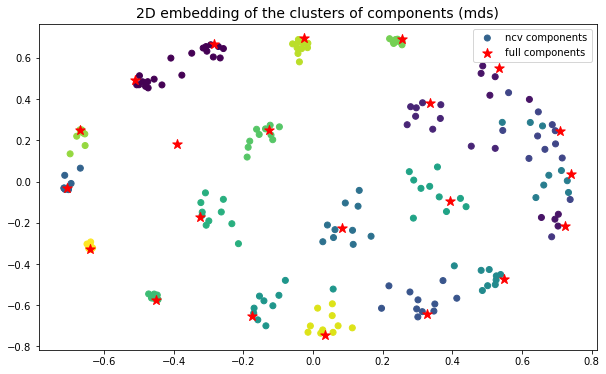

In [18]:
importances = lambda estimator : estimator['logistic'].coef_.reshape(-1)
components = lambda estimator : estimator['PCA'].components_
projections = lambda estimator : estimator['PCA'].transform(X)

df , stabilities , Consensus = collect_meta_importances(ncv , importances = importances , components = components, 
                                                        projections = projections , full_components = pca_full.components_ , 
                                                        full_projections = pca_full.transform(X) , clustering_space = "samples" ,
                                                        plot = True)
df.head()

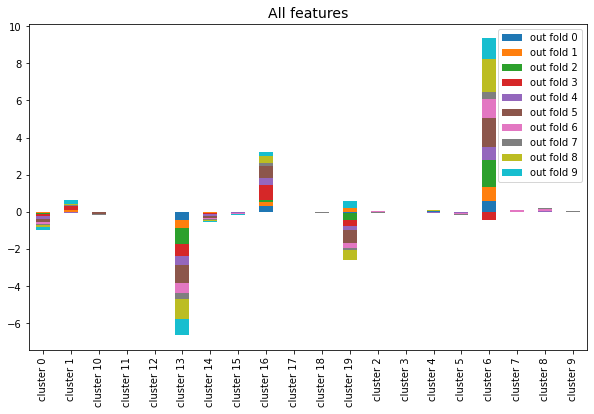

In [19]:
plot_feature_importances(df , normalize = False)